## Preamble

In [2]:
%load_ext autoreload
%autoreload 0

In [3]:
%autoreload

In [4]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [5]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [6]:
species_id = 102492

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 11860, 'position': 3681, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(1.1444092e-05, dtype=float32)
Frozen(SortedKeysDict({'strain': 198, 'sample': 11860, 'position': 3681, 'allele': 2}))


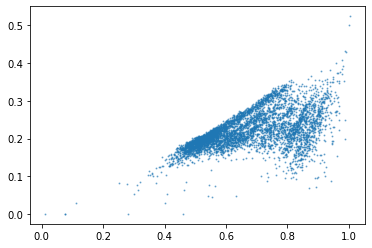

In [100]:
_g = fit.metagenotypes.to_estimated_genotypes(pseudo=0, fillna=True).random_sample(strain=100)

plt.scatter(
    pdist(sf.math.genotype_binary_to_sign(_g.values), metric='cosine'),
    squareform(_g.pdist()),
    s=1, alpha=0.5,
)

In [102]:
mgen_genotypes = fit.metagenotypes.to_estimated_genotypes(pseudo=0, fillna=True)#.random_sample(strain=5000)

dedup_thresh = 0.05

mgen_dedup_clust0 = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh * 5, n_clusters=None, affinity='cosine', linkage='single'
    ).fit_predict(sf.math.genotype_binary_to_sign(mgen_genotypes.values)),
    index=mgen_genotypes.strain,
)

mgen_dedup_clust0.value_counts()

5       257
282     127
45      101
29       85
389      76
       ... 
3947      1
1898      1
5992      1
3939      1
2047      1
Length: 6359, dtype: int64

In [115]:
mgen_dedup_clust = []

for clust0 in tqdm(mgen_dedup_clust0.value_counts().index):
    mgen_genotypes1 = mgen_genotypes.mlift('sel', strain=idxwhere(mgen_dedup_clust0 == clust0))
    if mgen_genotypes1.sizes['strain'] < 2:
        mgen_dedup_clust1 = pd.Series(0, index=mgen_genotypes1.strain)
    else:
        mgen_dedup_clust1 = pd.Series(
            AgglomerativeClustering(
                distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
            ).fit_predict(mgen_genotypes1.pdist()),
            index=mgen_genotypes1.strain,
        )
    mgen_dedup_clust.append(mgen_dedup_clust1.to_frame(name='clust1').assign(clust0=clust0))
    
mgen_dedup_clust = pd.concat(mgen_dedup_clust)

100%|██████████| 6359/6359 [00:16<00:00, 392.49it/s]


In [116]:
mgen_dedup_clust.groupby(['clust0', 'clust1']).apply(len).unstack().reindex(mgen_dedup_clust0.value_counts().index).head(20)

clust1,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
5,11.0,30.0,8.0,23.0,4.0,2.0,2.0,2.0,2.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
282,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,82.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2.0,4.0,48.0,2.0,2.0,6.0,1.0,1.0,17.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1313,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1496,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
mgen_genotypes_dedup = sf.Metagenotypes(
    fit.metagenotypes
    .to_series().unstack('sample')
    .groupby(mgen_dedup_clust.apply(lambda x: f'{x.clust0}-{x.clust1}', axis=1), axis='columns')
    .sum().rename_axis(columns='sample')
    .T.stack()
    .to_xarray()
)

AttributeError: 'Dataset' object has no attribute 'shape'

In [29]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc')
ref_genotypes = ref.mlift('sel', position=fit_genotypes.position).to_estimated_genotypes(pseudo=0)
ref_genotypes.sizes

Frozen({'strain': 1000, 'position': 3681})

In [24]:
position_meta = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([species_id])]

position_meta

,species_id,contig,contig_position,ref,alt
position,,,,,
14092,102492,.12718_7_53.1,14092,A,G
14137,102492,.12718_7_53.1,14137,T,C
14668,102492,.12718_7_53.1,14668,A,G
15562,102492,.12718_7_53.1,15562,T,C
15564,102492,.12718_7_53.1,15564,C,T
...,...,...,...,...,...
3454569,102492,.12718_7_53.57,7365,A,C
3454572,102492,.12718_7_53.57,7368,C,G
3455438,102492,.12718_7_53.57,8234,G,A


In [31]:
fit_dist = fit_genotypes.discretized().pdist()
ref_dist = ref_genotypes.discretized().pdist()

In [34]:
dedup_thresh = 0.05

fit_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_genotypes.strain.astype(int),
)
ref_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(ref_dist),
    index=ref_genotypes.strain,
)

In [36]:
fit_genotypes_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [37]:
ref_genotypes_dedup = sf.Genotypes(ref_genotypes.to_series().unstack('strain').groupby(ref_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [38]:
(fit_genotypes.sizes['strain'], fit_genotypes_dedup.sizes['strain']), (ref_genotypes.sizes['strain'], ref_genotypes_dedup.sizes['strain'])

((198, 198), (1000, 752))

In [ ]:
_g_ref = ref_genotypes_dedup#.random_sample(position=20000)
r2_ref = (1 - pdist(_g_ref.values.T, 'correlation'))**2

_g_fit = fit_genotypes_dedup#.sel(position=_g_ref.position)
r2_fit = (1 - pdist(_g_fit.values.T, 'correlation'))**2

In [134]:
np.mean(r2_ref), np.mean(r2_fit)

(0.01171654808264688, 0.017961986997681312)

In [135]:
np.median(r2_ref), np.median(r2_fit)

(0.00234095548439049, 0.005040182212089999)

In [136]:
np.quantile(r2_ref, 0.9), np.quantile(r2_fit, 0.9)

(0.022544897916700616, 0.04028370549637712)

In [138]:
from scipy.stats import mannwhitneyu, wilcoxon

n = 10000
wilcoxon(r2_ref[:n], r2_fit[:n])

WilcoxonResult(statistic=17084664.0, pvalue=1.3385440094220457e-165)

In [39]:
ld = {}
for contig, pos in position_meta.loc[ref_genotypes_dedup.position].groupby('contig'):
    print(contig)
    g = ref_genotypes_dedup.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ref_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


In [40]:
ld = {}
for contig, pos in position_meta.loc[fit_genotypes_dedup.position].groupby('contig'):
    print(contig)
    g = fit_genotypes_dedup.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
fit_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


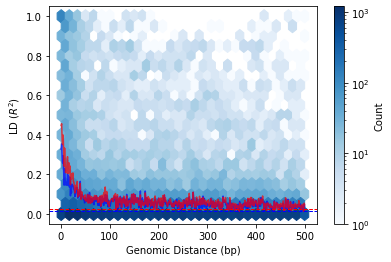

In [62]:
stepsize = 1
right = 500

d = fit_ld[lambda p: p.x < right]
bins_est = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()


fig = plt.figure()

plt.hexbin('x', 'r2', data=d, cmap='Blues', norm=mpl.colors.LogNorm(), mincnt=1, gridsize=(30, 10), label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes', alpha=0.7)
ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes', alpha=0.7)

ax.axhline(np.mean(r2_ref), lw=1, color='blue', linestyle='--')
ax.axhline(np.mean(r2_fit), lw=1, color='red', linestyle='--')


# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')

fig.savefig(f'fig/ld_decay_{species_id}.png', dpi=400)

In [ ]:
stepsize = 1
right = 10000

d = fit_ld[lambda p: p.x < right]
bins_est = {}
for start in range(1, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.quantile(0.9)
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(1, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.quantile(0.9)

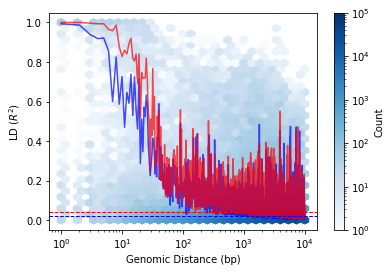

In [141]:
fig = plt.figure()

plt.hexbin('x', 'r2', data=fit_ld[lambda p: p.x < right], cmap='Blues', norm=mpl.colors.LogNorm(vmin=1, vmax=1e5), xscale='log', gridsize=30, mincnt=1, label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes', alpha=0.7)
ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes', alpha=0.7)

ax.axhline(np.quantile(r2_ref, 0.9), lw=1, color='blue', linestyle='--')
ax.axhline(np.quantile(r2_fit, 0.9), lw=1, color='red', linestyle='--')

# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')

fig.savefig(f'fig/ld_decay_{species_id}_90th.png', dpi=400)

In [140]:
pd.Series(bins_est)[lambda x: x < 0.5], pd.Series(bins_ref)[lambda x: x < 0.5]

(28      0.496823
 29      0.240349
 31      0.426642
 33      0.458512
 35      0.265804
           ...   
 9995    0.019554
 9996    0.038827
 9997    0.012623
 9998    0.024635
 9999    0.018401
 Length: 9964, dtype: float64,
 11      0.469347
 18      0.460519
 20      0.285268
 22      0.346361
 27      0.384298
           ...   
 9995    0.014525
 9996    0.011938
 9997    0.016717
 9998    0.027564
 9999    0.022165
 Length: 9976, dtype: float64)

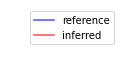

In [61]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.plot([], color='blue', label=f'reference', alpha=0.7)
ax.plot([], color='red', label=f'inferred', alpha=0.7)
ax.legend()  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.axis('off')
fig.savefig(f'fig/ld_decay_{species_id}_legend.png', dpi=400)